# Try Li Plating Sub Models

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [4]:
parameter_values = pybamm.ParameterValues("OKane2022")
parameter_values.search('plating')

Exchange-current density for plating [A.m-2]	<function plating_exchange_current_density_OKane2020 at 0x000001F504338940>
Lithium plating kinetic rate constant [m.s-1]	1e-09
Lithium plating transfer coefficient	0.65


In [3]:
spm_li = pybamm.lithium_ion.SPM(
    {
        "lithium plating": "irreversible",
    }
)

spm_li_r = pybamm.lithium_ion.SPM(
    {
        "lithium plating": "reversible",
    }
)

spm_li_pr = pybamm.lithium_ion.SPM(
    {
        "lithium plating": "partially reversible",
    }
)
param=spm_li.param

In [5]:
c_rate_d = '2C'
c_rate_c = '2C'

In [6]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
# experiment = pybamm.Experiment(
#     [
#         ("Discharge at "+c_rate_d+dis_set,
#          "Rest for 5 min",
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50")
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [7]:
sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=0)
solution1 = sol_long


In [8]:
# parameter_values.update(
#     {
#       "Exchange-current density for plating [A.m-2]":0.001,
#       "Lithium plating transfer coefficient": 0.5,
#       "Dead lithium decay constant [s-1]": 1E-4,
#         "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )

sim_long = pybamm.Simulation(spm_li_r, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=0)
solution2 = sol_long

In [9]:
# parameter_values.update(
#     {
#       "Exchange-current density for plating [A.m-2]":0.002,
#       "Lithium plating transfer coefficient": 0.7,
#       "Dead lithium decay rate [s-1]": 1E-4,
#     },
#     check_already_exists=False,
# )

sim_long = pybamm.Simulation(spm_li_pr, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=0)
solution3 = sol_long

In [10]:
t1 =  solution1["Time [s]"].entries
V1 =  solution1["Terminal voltage [V]"].entries
I1 =  solution1["Current [A]"].entries
Q1 = -solution1['Discharge capacity [A.h]'].entries
Q_Li1 = solution1["Loss of capacity to lithium plating [A.h]"].entries
I_Li1 = solution1["X-averaged lithium plating interfacial current density"].entries

I_de1 = solution1["X-averaged negative electrode interfacial current density"].entries
I_st1 = solution1["X-averaged lithium plating interfacial current density"].entries
I_to1 = solution1["Sum of x-averaged negative electrode volumetric interfacial current densities"].entries

In [11]:
t2 =  solution2["Time [s]"].entries
V2 =  solution2["Terminal voltage [V]"].entries
I2 =  solution2["Current [A]"].entries
Q2 = -solution2['Discharge capacity [A.h]'].entries
Q_Li2 = solution2["Loss of capacity to lithium plating [A.h]"].entries
I_Li2 = solution2["X-averaged lithium plating interfacial current density"].entries

I_de2 = solution2["X-averaged negative electrode interfacial current density"].entries
I_st2 = solution2["X-averaged lithium plating interfacial current density"].entries
I_to2 = solution2["Sum of x-averaged negative electrode volumetric interfacial current densities"].entries

In [12]:
t3 =  solution3["Time [s]"].entries
V3 =  solution3["Terminal voltage [V]"].entries
I3 =  solution3["Current [A]"].entries
Q3 = -solution3['Discharge capacity [A.h]'].entries
Q_Li3 = solution3["Loss of capacity to lithium plating [A.h]"].entries
I_Li3 = solution3["X-averaged lithium plating interfacial current density"].entries

I_de3 = solution3["X-averaged negative electrode interfacial current density"].entries
I_st3 = solution3["X-averaged lithium plating interfacial current density"].entries
I_to3 = solution3["Sum of x-averaged negative electrode volumetric interfacial current densities"].entries

In [13]:
linestyles = ["dashed", "dotted", "solid"]
colors = ["tab:purple", "tab:cyan", "tab:red", "tab:green", "tab:blue"]

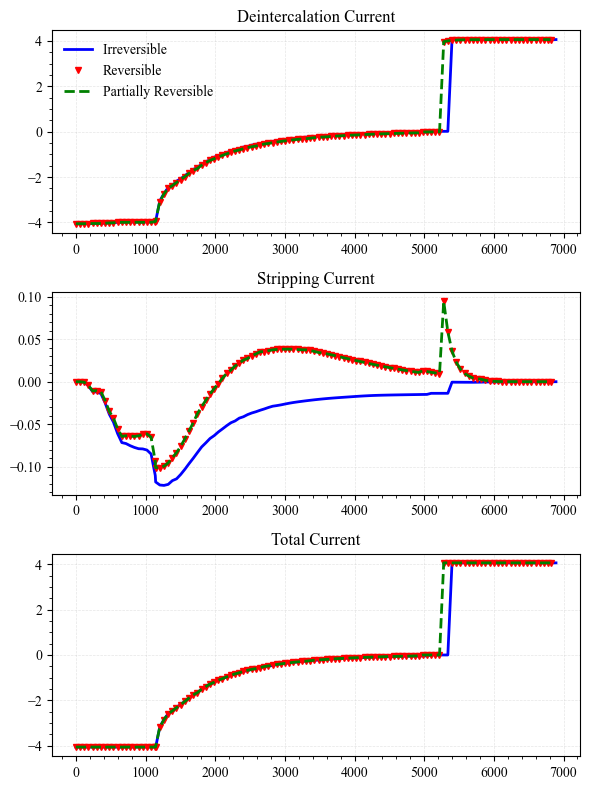

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
ax1 = axes.flat[0]
ax1.plot(t1,I_de1,'b')
ax1.plot(t2,I_de2,'rv')
ax1.plot(t3,I_de3,'g--')
ax1.set_title('Deintercalation Current')
ax2 = axes.flat[1]
ax2.plot(t1,I_st1,'b')
ax2.plot(t2,I_st2,'rv')
ax2.plot(t3,I_st3,'g--')
ax2.set_title('Stripping Current')
ax3=axes.flat[2]
ax3.plot(t1,I_to1,'b')
ax3.plot(t2,I_to2,'rv')
ax3.plot(t3,I_to3,'g--')
ax3.set_title('Total Current')
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
fig.tight_layout()
plt.savefig(fig_DIR+'plating_models_current'+'.png')

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv')
ax1.plot(t3,V3,'g--')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[1]
ax2.plot(t1,Q_Li1,'b')
ax2.plot(t2,Q_Li2,'rv')
ax2.plot(t3,Q_Li3,'g--')
ax2.set_title('Capacity lost due to plating [Ah]')
ax3=axes.flat[2]
ax3.plot(t1,I_Li1,'b')
ax3.plot(t2,I_Li2,'rv')
ax3.plot(t3,I_Li3,'g--')
ax3.set_title('Lithium plating interfacial current density')
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
fig.tight_layout()
plt.savefig(fig_DIR+'plating_models_compare'+'.png')